# **TESIS: PREDICCIÓN DE TUMORES EN EL CEREBRO**

### ***Carga de librerías y base de datos***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Colab Notebooks/Modern AI Portfolio/Healthcare AI/Healthcare AI Datasets/Brain_MRI/

/content/drive/My Drive/Colab Notebooks/Modern AI Portfolio/Healthcare AI/Healthcare AI Datasets/Brain_MRI


In [ ]:
brain_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Modern AI Portfolio/Healthcare AI/Healthcare AI Datasets/Brain_MRI/data_mask.csv')

### ***Exploración de los datos***

In [ ]:
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x = ["SIN TUMOR", "CON TUMOR"], y = brain_df['mask'].value_counts(), text = brain_df['mask'].value_counts(), textposition = 'auto')])
fig.update_layout(
    font_family="Courier New",
    font_color="black",
    font_size=25
)
fig.show()

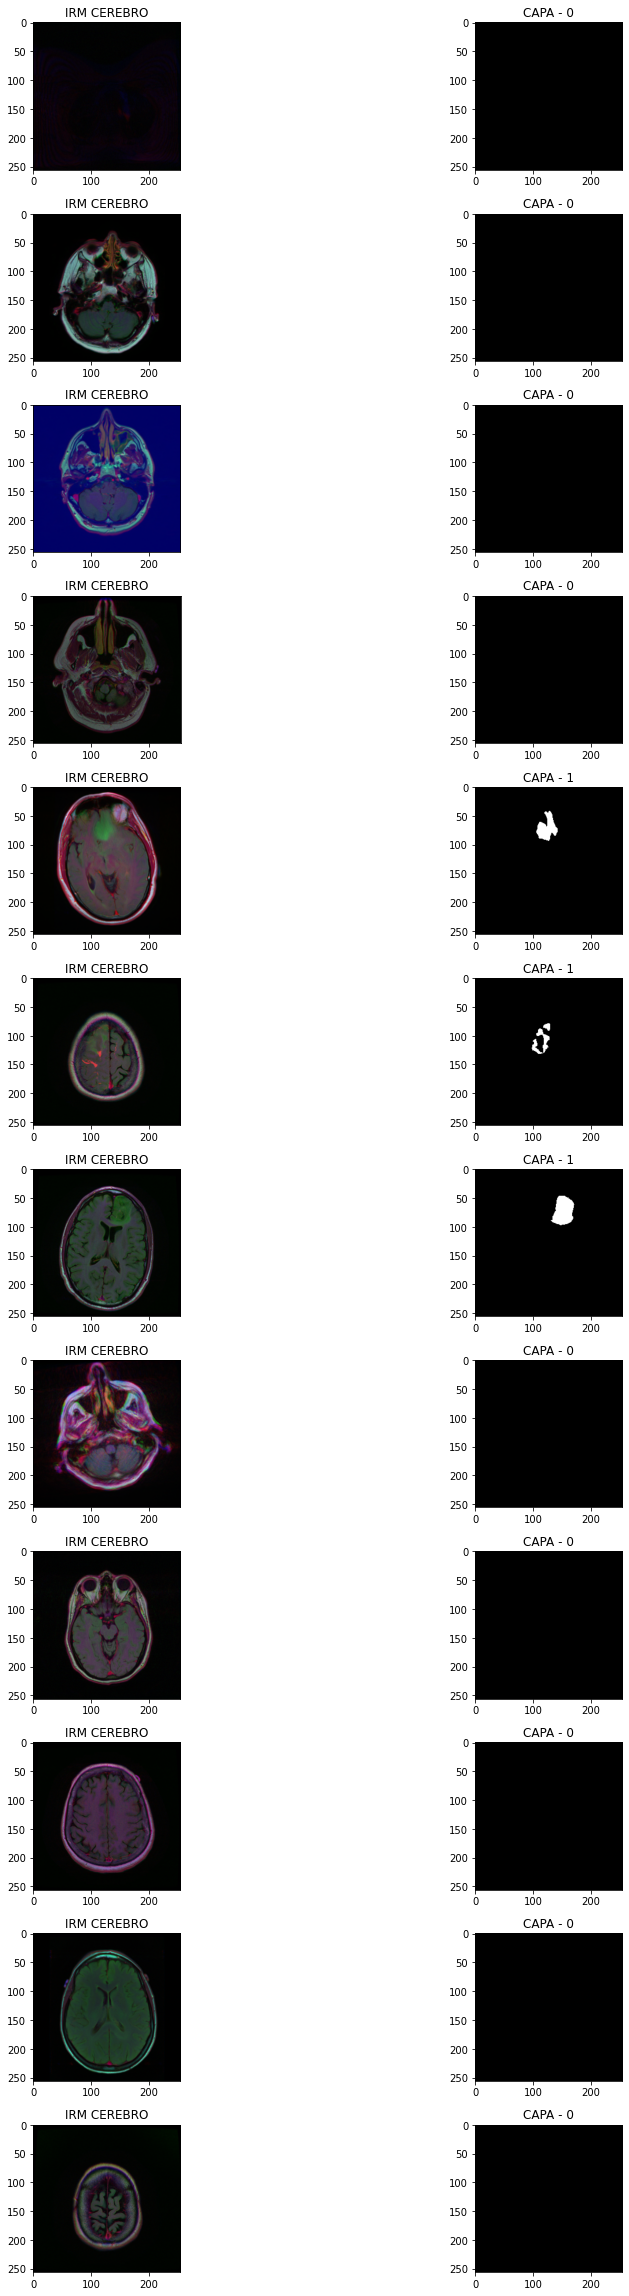

In [ ]:
import random 
fig, axs = plt.subplots(12, 2, figsize = (16,32))
count = 0
for x in range(12):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("IRM CEREBRO")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("CAPA - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1
fig.tight_layout()

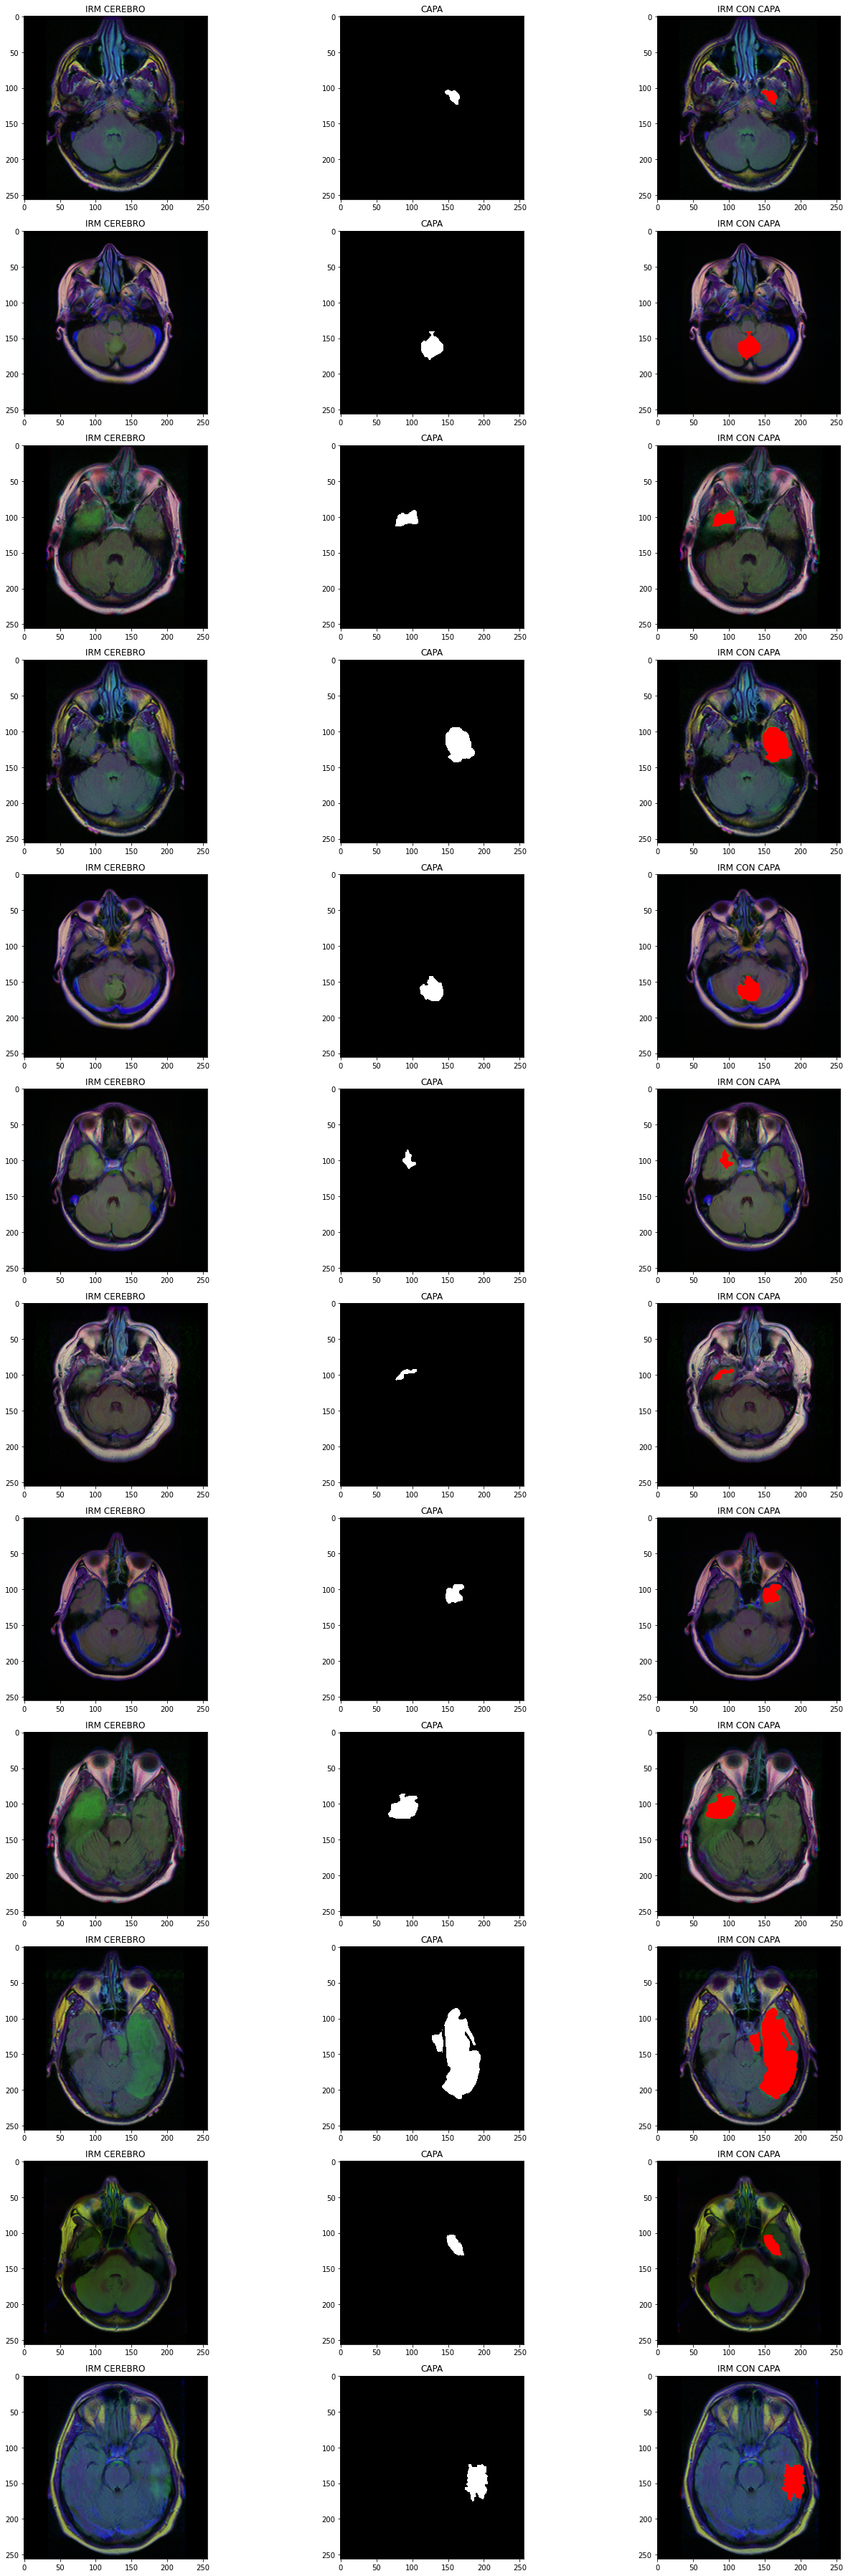

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('IRM CEREBRO')
    axs[count][0].imshow(img)
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('CAPA')
    axs[count][1].imshow(mask, cmap = 'gray')
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('IRM CON CAPA')
    axs[count][2].imshow(img)
    count += 1
fig.tight_layout()

### ***Modelo de Clasificación (Existe tumor o no)***

In [ ]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
 from keras_preprocessing.image import ImageDataGenerator
 datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = "training",
    batch_size = 16,
    shuffle = True,
    class_mode = "categorical",
    target_size = (256,256))

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = "validation",
    batch_size = 16,
    shuffle = True,
    class_mode = "categorical",
    target_size = (256,256))

test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = "categorical",
    target_size = (256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

94781440/94765736 [==============================] - 4s 0us/step


In [ ]:
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)

In [ ]:
checkpointer = ModelCheckpoint(filepath = "/content/drive/My Drive/Tesis/clas_param1.hdf5", verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 16, epochs = 1000, validation_data = valid_generator, validation_steps = valid_generator.n // 16, callbacks = [checkpointer, earlystopping])

Epoch 1/1000
177/177 [==============================] - 46s 230ms/step - loss: 1.0159 - accuracy: 0.6789 - val_loss: 0.7438 - val_accuracy: 0.3871

Epoch 00001: val_loss improved from inf to 0.74383, saving model to /content/drive/My Drive/Tesis/clas_param1.hdf5
Epoch 2/1000
177/177 [==============================] - 41s 229ms/step - loss: 0.4758 - accuracy: 0.7932 - val_loss: 7.3297 - val_accuracy: 0.6452

Epoch 00002: val_loss did not improve from 0.74383
Epoch 3/1000
177/177 [==============================] - 41s 231ms/step - loss: 0.4287 - accuracy: 0.8189 - val_loss: 0.6582 - val_accuracy: 0.6431

Epoch 00003: val_loss improved from 0.74383 to 0.65818, saving model to /content/drive/My Drive/Tesis/clas_param1.hdf5
Epoch 4/1000
177/177 [==============================] - 41s 233ms/step - loss: 0.3846 - accuracy: 0.8371 - val_loss: 0.6499 - val_accuracy: 0.6512

Epoch 00004: val_loss improved from 0.65818 to 0.64992, saving model to /content/drive/My Drive/Tesis/clas_param1.hdf5
Epoc

In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/Tesis/clas_mod1.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open("/content/drive/My Drive/Tesis/clas_mod1.json", 'r') as json_file:
  json_savedModel = json_file.read()
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights("/content/drive/My Drive/Tesis/clas_param1.hdf5")
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"]) 

In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose = 1)

36/36 [==============================] - 164s 4s/step


In [ ]:
predict = []
for i in test_predict:
  predict.append(str(np.argmax(i)))
predict = np.asarray(predict)

In [ ]:
original = np.array(test['mask'])[:len(predict)]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.9756944444444444

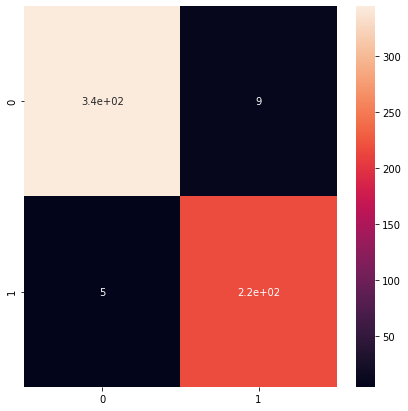

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       353
           1       0.96      0.98      0.97       223

   micro avg       0.98      0.98      0.98       576
   macro avg       0.97      0.98      0.97       576
weighted avg       0.98      0.98      0.98       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



### ***Modelo para localizar el tumor***

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
from utilities import DataGenerator
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):
  X_copy = X
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 
  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)
  X = Add()([X,X_copy])
  X = Activation('relu')(X)
  return X

In [ ]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])
  return merge

In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)
conv5_in = resblock(pool_4, 256)
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)
model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss =focal_tversky,  metrics = [tversky])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Tesis/ResUNet_param.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 1000, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/1000
72/72 [==============================] - 60s 795ms/step - loss: 0.8561 - tversky: 0.1848 - val_loss: 0.7615 - val_tversky: 0.3044

Epoch 00001: val_loss improved from inf to 0.76146, saving model to /content/drive/My Drive/Tesis/ResUNet_param.hdf5
Epoch 2/1000
72/72 [==============================] - 14s 197ms/step - loss: 0.4707 - tversky: 0.6314 - val_loss: 0.6153 - val_tversky: 0.4755

Epoch 00002: val_loss improved from 0.76146 to 0.61527, saving model to /content/drive/My Drive/Tesis/ResUNet_param.hdf5
Epoch 3/1000
72/72 [==============================] - 13s 182ms/step - loss: 0.3834 - tversky: 0.7196 - val_loss: 0.6945 - val_tversky: 0.3825

Epoch 00003: val_loss did not improve from 0.61527
Epoch 4/1000
72/72 [==============================] - 13s 183ms/step - loss: 0.3340 - tversky: 0.7665 - val_loss: 0.6215 - val_tversky: 0.4684

Epoch 00004: val_loss did not improve from 0.61527
Epoch 5/1000
72/72 [==============================] - 13s 184ms/step - loss: 0.3200 

In [ ]:
model_json = model_seg.to_json()
with open("/content/drive/My Drive/Tesis/ResUNet_mod.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky
with open("/content/drive/My Drive/Tesis/ResUNet_mod.json", 'r') as json_file:
  json_savedModel = json_file.read()

# Load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights("/content/drive/My Drive/Tesis/ResUNet_param.hdf5")
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
from utilities import prediction
image_id, mask, has_mask = prediction(test, model, model_seg)
df_pred = pd.DataFrame({'image_path': image_id, 'predicted_mask': mask, 'has_mask': has_mask})
df_pred = test.merge(df_pred, on = 'image_path')

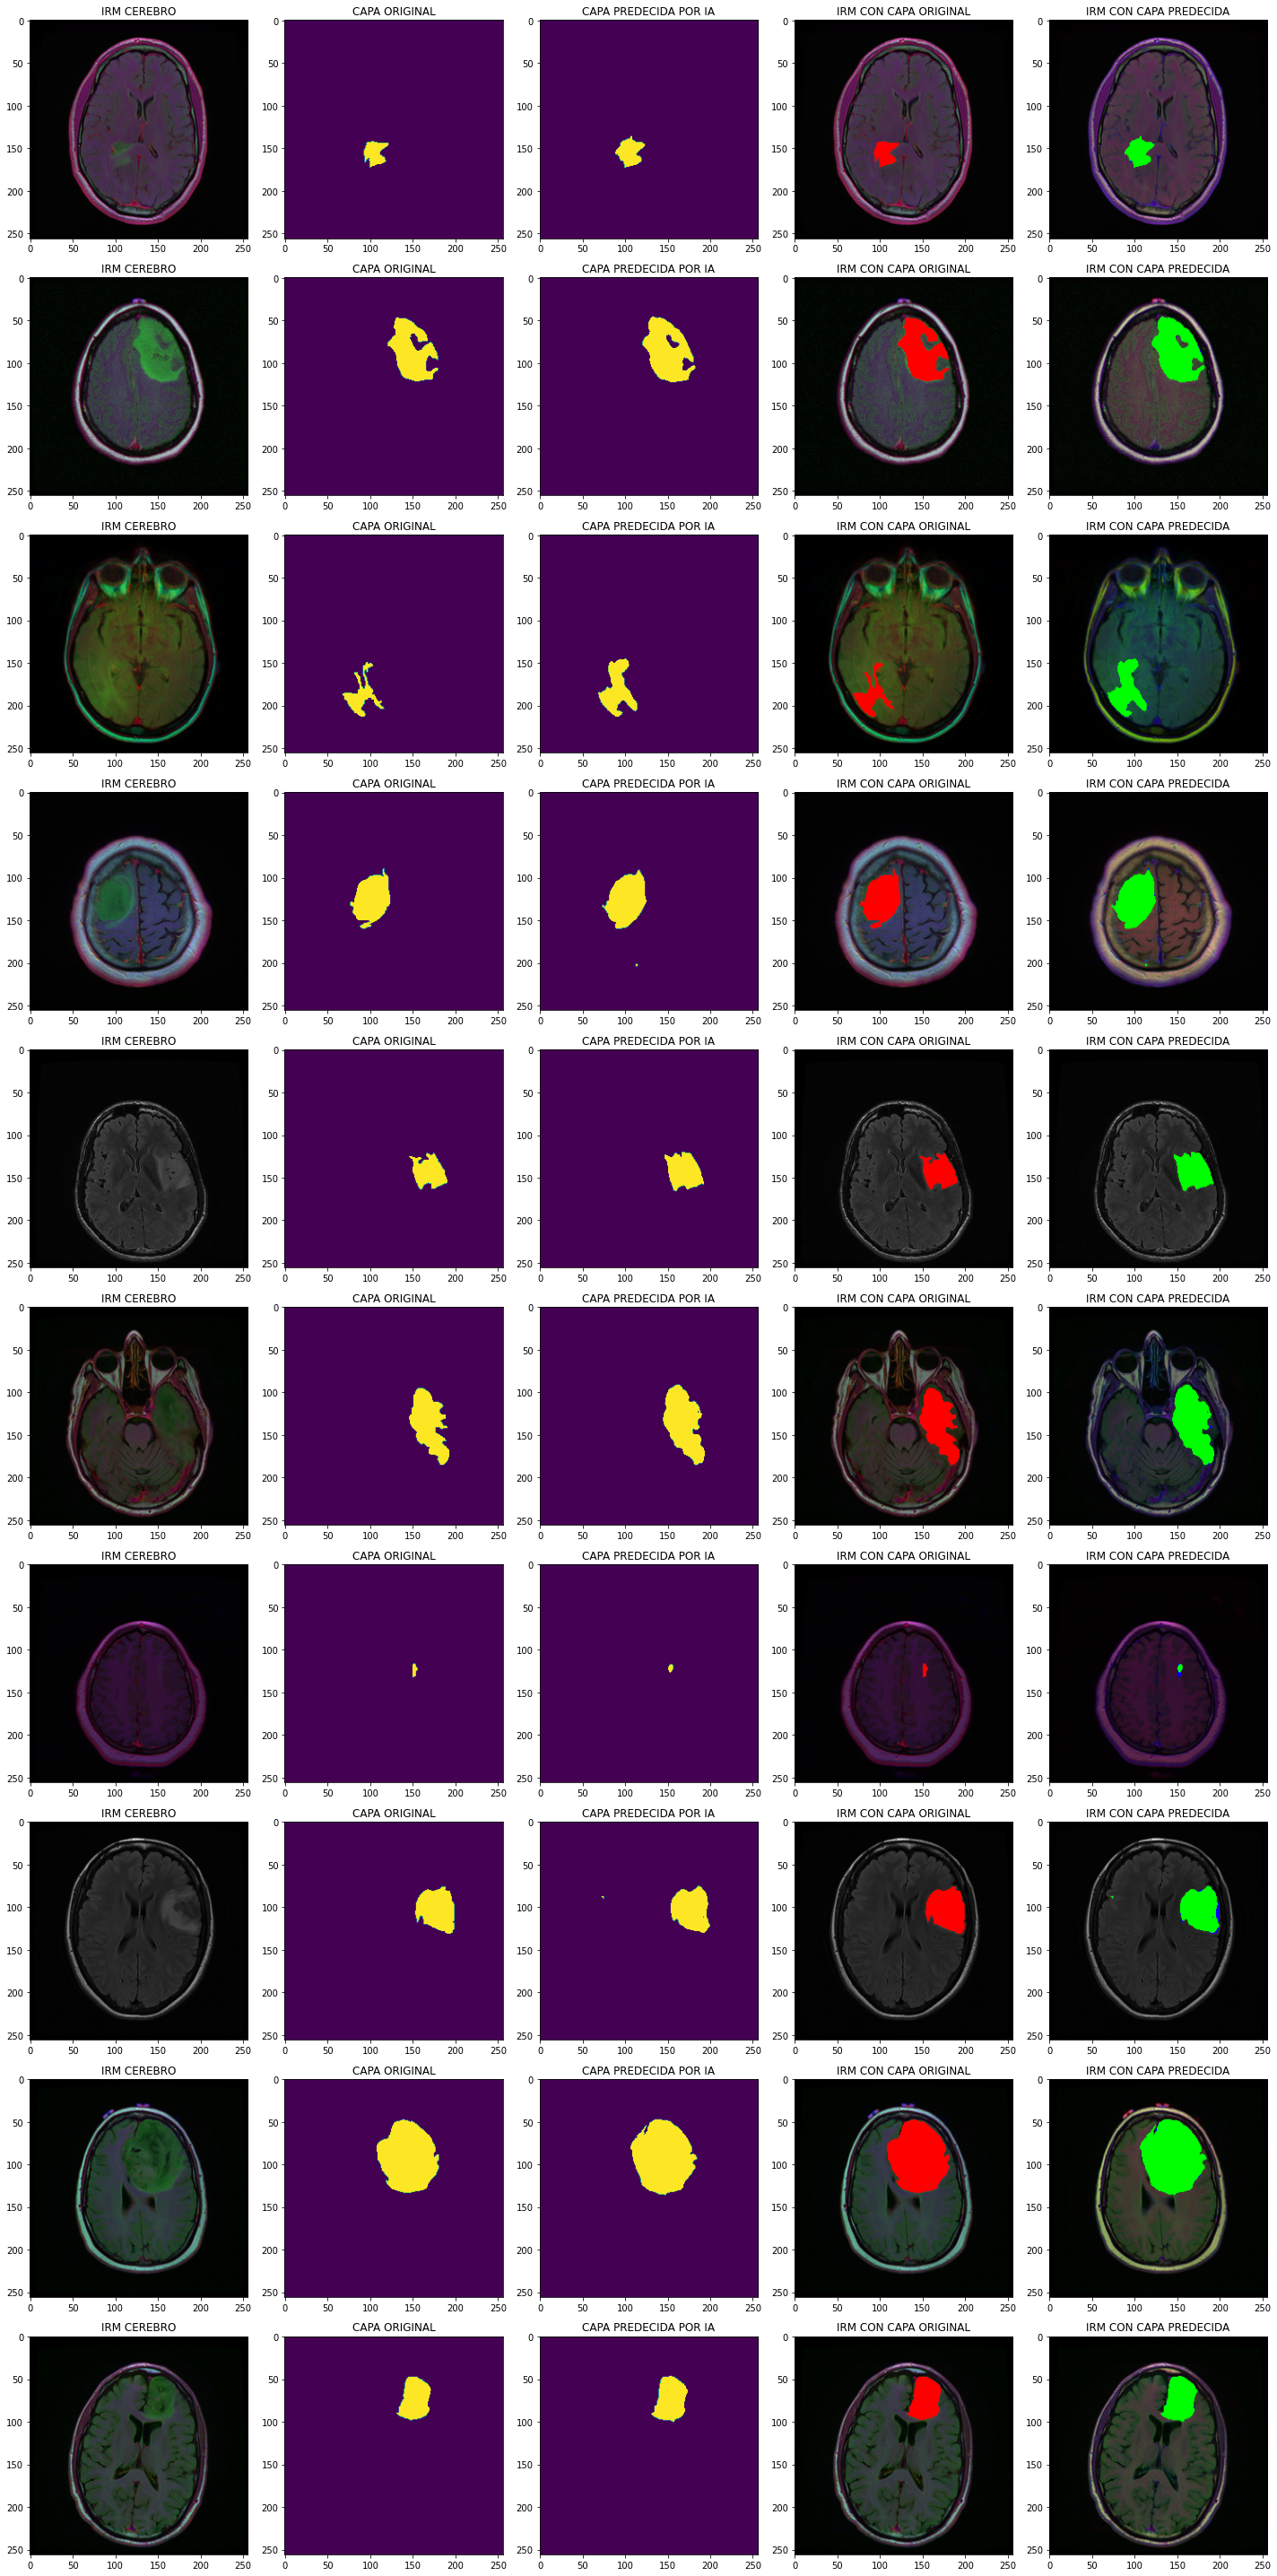

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30,40))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("IRM CEREBRO")
    axs[count][0].imshow(img)
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("CAPA ORIGINAL")
    axs[count][1].imshow(mask)
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("CAPA PREDECIDA POR IA")
    axs[count][2].imshow(predicted_mask)
    img[mask == 255] = (255,0,0)
    axs[count][3].title.set_text("IRM CON CAPA ORIGINAL")
    axs[count][3].imshow(img)
    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0,255,0)
    axs[count][4].title.set_text("IRM CON CAPA PREDECIDA")
    axs[count][4].imshow(img_)
    count += 1
  fig.tight_layout()